In [1]:
import numpy as np
import qinfer as qi
from functools import partial

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [3]:
omega_max = 100
true_omega = 70.3
ts = np.arange(1, 51) / (2 * omega_max)
n_shots = 1
pr1s = np.sin(true_omega * ts / 2) ** 2
counts = np.random.binomial(n_shots, p=pr1s)

In [4]:
# the binomial noise should leave (almost) unaltered the balance 0_VS_1, but as a double check...
np.mean(counts)

0.5

In [5]:
data = np.column_stack([counts, ts, np.ones_like(counts) * n_shots])
mean, cov = qi.simple_est_prec(data, freq_max=omega_max)

print(mean, cov)

71.5492869861 1.33530586319


In [19]:
data[0:10]

array([[ 0.   ,  0.005,  1.   ],
       [ 0.   ,  0.01 ,  1.   ],
       [ 0.   ,  0.015,  1.   ],
       [ 0.   ,  0.02 ,  1.   ],
       [ 0.   ,  0.025,  1.   ],
       [ 0.   ,  0.03 ,  1.   ],
       [ 0.   ,  0.035,  1.   ],
       [ 1.   ,  0.04 ,  1.   ],
       [ 1.   ,  0.045,  1.   ],
       [ 0.   ,  0.05 ,  1.   ]])

In [6]:
model = qi.BinomialModel(qi.SimplePrecessionModel(0))
prior = qi.UniformDistribution([0, 1])

data = qi.simple_est.load_data_or_txt(data, [
    ('counts', 'uint'),
    ('t', float),
    ('n_shots', 'uint')
])

outcomes, expparams = qi.simple_est.data_to_params(data,
    model.expparams_dtype,
    cols_expparams={
        'x': (1, 't'),
        'n_meas': (2, 'n_shots')
    }
)

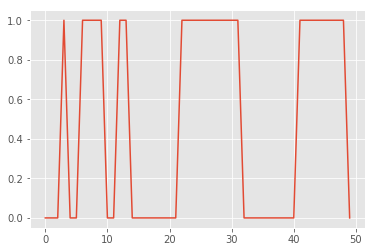

In [7]:
other_noises_level = 115/250 

counts = np.random.binomial(n_shots, p=np.sin(true_omega * ts / 2) ** 2)
plt.plot(counts)

In [8]:
for i in range(len(counts)):
    if counts[i]==1:
        counts[i] = np.random.binomial(1, p = other_noises_level)
        
np.sum(counts)/len(counts)

data = np.column_stack([counts, ts, np.ones_like(counts) * n_shots])
mean, cov = qi.simple_est_prec(data, freq_max=omega_max)

print(mean, cov)

6.75551656856 1.17499503098


In [9]:
class AsymmetricLossModel(qi.DerivedModel, qi.FiniteOutcomeModel):
    """
    Model representing the case in which a two-outcome model is subject
    to asymmetric loss, such that
    
        Pr(1 | modelparams; expparams) = η Pr(1 | modelparams; expparams, no loss),
        Pr(0 | modelparams; expparams)
            = Pr(0 | modelparams; expparams, no loss) + (1 - η) Pr(1 | modelparams; expparams, no loss)
            = 1 - Pr(1 | modelparams; expparams, no loss) + (1 - η) Pr(1 | modelparams; expparams, no loss)
            = 1 - η Pr(1 | modelparams; expparams, no loss)
            = 1 - Pr(1 | modelparams; expparams).
        
    This model considers η to be *known* and given at initialization time, rather than as a model parameter to be
    estimated.
    """
    
    def __init__(self, underlying_model, eta=1.0):
        super(AsymmetricLossModel, self).__init__(underlying_model)
        self._eta = float(eta)
        
        if not (underlying_model.is_n_outcomes_constant and underlying_model.n_outcomes(None) == 2):
            raise ValueError("Decorated model must be a two-outcome model.")
    
    ## METHODS ##
    

    def likelihood(self, outcomes, modelparams, expparams):
        # By calling the superclass implementation, we can consolidate
        # call counting there.
        super(AsymmetricLossModel, self).likelihood(outcomes, modelparams, expparams)
        
        pr1 = self._eta * self.underlying_model.likelihood(
            np.array([1], dtype='uint'),
            modelparams,
            expparams
        )[0, :, :]
        
        # Now we concatenate over outcomes.
        L = qi.FiniteOutcomeModel.pr0_to_likelihood_array(outcomes, 1 - pr1)
        assert not np.any(np.isnan(L))
        return L

In [10]:
base_model = qi.SimplePrecessionModel(0)
no_loss_model = qi.BinomialModel(base_model)
lossy_model = qi.BinomialModel(AsymmetricLossModel(base_model, eta=other_noises_level))

In [11]:
def heuristic(updater, n_shots=1, max_n_experiments=500):
    ts = np.arange(1, 1 + max_n_experiments) / (2 * omega_max)
    expparams = np.empty((1,), dtype=updater.model.expparams_dtype)
    expparams['n_meas'] = n_shots
    
    t_iter = iter(ts)
    
    def next_experiment():
        expparams['x'] = next(t_iter)
        return expparams
        
    return next_experiment

In [12]:
perf_matched = qi.perf_test_multiple(
    40, lossy_model, 4000, qi.UniformDistribution([0, omega_max]), 50, heuristic
)

In [13]:
perf_mismatched = qi.perf_test_multiple(
    40, no_loss_model, 4000, qi.UniformDistribution([0, omega_max]), 50, heuristic,
    true_model=lossy_model
)

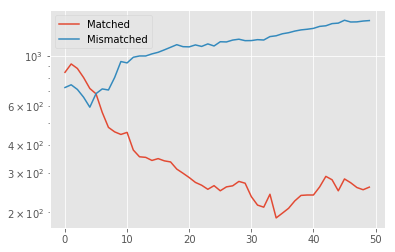

In [14]:
plt.semilogy(np.mean(perf_matched['loss'], axis=0), label='Matched')
plt.semilogy(np.mean(perf_mismatched['loss'], axis=0), label='Mismatched')
plt.legend()

In [16]:
perf_matched_repeated = qi.perf_test_multiple(
    10, lossy_model, 16000, qi.UniformDistribution([0, omega_max]), 50, partial(heuristic, n_shots=1)
)

In [17]:
perf_mismatched_repeated = qi.perf_test_multiple(
    10, no_loss_model, 16000, qi.UniformDistribution([0, omega_max]), 50, partial(heuristic, n_shots=1),
    true_model=lossy_model, allow_failures=True
)

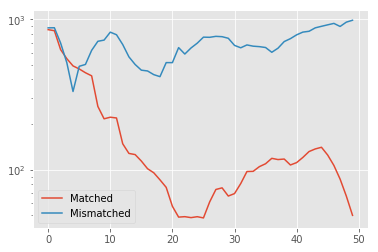

In [18]:
plt.semilogy(np.mean(perf_matched_repeated['loss'], axis=0), label='Matched')
plt.semilogy(np.mean(perf_mismatched_repeated['loss'], axis=0), label='Mismatched')
plt.legend()